# Linear classifier

Classifier: SVM

$$
\argmin_{\theta} \sum_{i=1}^n l(max(0,1-y_if_{\theta}(x_i)),y_i) + \lambda \Omega_2(\theta)
$$

- Hinge loss 
- L2 Regularizer (Squared Euclidean Norm)
- Numeric solution using Stochastic Gradient Descent Method (SGD)
- ERM is about the *objective* (minimizing the empirical risk), while gradient descent is about the *method* (an algorithm to find the parameters that minimize the empirical risk).

1. Calculate stopping criterion

$$
\parallel \Theta^t - \Theta^{t+1} \parallel > \epsilon
$$ 

L2 Norm is used, hence:

$$
\|\Theta^t - \Theta^{t+1}\|_2 = \sqrt{(\Theta^t_1 - \Theta^{t+1}_1)^2 + (\Theta^t_2 - \Theta^{t+1}_2)^2 + \cdots + (\Theta^t_n - \Theta^{t+1}_n)^2}
$$

2. Claculate gradient for Hinge loss and L2 Regularizer

Hinge loss with linear model:

$$
max(0, 1-y_i(x_i*\theta_i))
$$

Gradient for a single instance:

$$
\nabla_{\theta} L(\theta) = \frac{\partial l(max(0, 1-y_i(x_i*\theta)))}{\partial \theta} + \frac{\lambda}{n}\frac{\partial \Omega_2(\theta)}{\partial \theta}
$$

Partial derivation of the Hinge loss:

$$
\nabla_{\theta} L(\theta) = 
\begin{cases}
0, & \text{if } 1 - y_i (\mathbf{x}_i \cdot \theta) \leq 0 \\
-y_i \mathbf{x}_i, & \text{if } 1 - y_i (\mathbf{x}_i \cdot \theta) > 0 
\end{cases}
$$


Partial derivation of the L2 Regularizer:
$$
\nabla_{\theta} \Omega_2(\theta) = \theta
$$

Hence, combination:
$$
\nabla_{\theta} L(\theta) = 
\begin{cases}
\frac{\lambda}{n}\theta, & \text{if } 1 - y_i (\mathbf{x}_i \cdot \theta) \leq 0 \\
-y_i \mathbf{x}_i + \frac{\lambda}{n}\theta, & \text{if } 1 - y_i (\mathbf{x}_i \cdot \theta) > 0 
\end{cases}
$$




3. Calculate step size alpha

$$
\alpha(t) = \frac{\alpha_0}{1 + \text{decay\_rate} \cdot t}
$$

## Learn the classifier


In [6]:
from scipy.io import loadmat
from sklearn.model_selection import ParameterGrid
import matplotlib.pyplot as plt
import numpy as np
import sys
sys.path.append('..')
from linear_classifier_helper import LinearClassifierHelper
from dataset import FeatureEngineeredDataset

file_path = "../../data/laser.mat"
mat_dict = loadmat(file_path)

dataset = FeatureEngineeredDataset(mat_dict, "X", "Y", "r2")

Checking path: /Users/marleenstreicher/Documents/git/IDA_Laser/IDA_Laser/data_split_indices.pkl
Path exists: True


In [7]:
param_grid = {
    'lambda_value': [0.001, 0.01, 0.1, 1.0, 10.0],
    'alpha_0': [0.001, 0.01, 0.1],
    'decay_rate': [0.001, 0.01, 0.1],
    'epsilon': [1e-4, 1e-5, 1e-6]
}

def train_model_with_params(params):
    theta = LinearClassifierHelper.reg_erm_stoch(dataset.train_inputs, dataset.train_labels, 
                                                lambda_value=params['lambda_value'], 
                                                epsilon=params['epsilon'], 
                                                alpha_0=params['alpha_0'], 
                                                decay_rate=params['decay_rate'])

    predictions, raw_predictions, inputs, theta = LinearClassifierHelper.predict(dataset.test_inputs, theta)
    accuracy = LinearClassifierHelper.evaluate(raw_predictions, dataset.test_labels)

    return accuracy


best_params = None
best_score = float('-inf')

for params in ParameterGrid(param_grid):
    score = train_model_with_params(params)
    if score > best_score:
        best_score = score
        best_params = params

print("Best parameters found:", best_params)

Best parameters found: {'alpha_0': 0.001, 'decay_rate': 0.001, 'epsilon': 0.0001, 'lambda_value': 0.001}


In [8]:
# best_params = {'alpha_0': 0.001, 'decay_rate': 0.001, 'epsilon': 0.0001, 'lambda_value': 0.001}

optimal_theta = LinearClassifierHelper.reg_erm_stoch(dataset.train_inputs, dataset.train_labels, best_params['lambda_value'], best_params['epsilon'], best_params['alpha_0'], best_params['decay_rate'])
print(optimal_theta)

[0.16782058]


In [9]:
predictions, raw_predictions, inputs, theta= LinearClassifierHelper.predict(dataset.test_inputs, optimal_theta)

accuracy = LinearClassifierHelper.evaluate(predictions, dataset.test_labels)
print(accuracy)

0.5


Not the desired outcome. All predictions were classified in the same category. 

### Visualisation

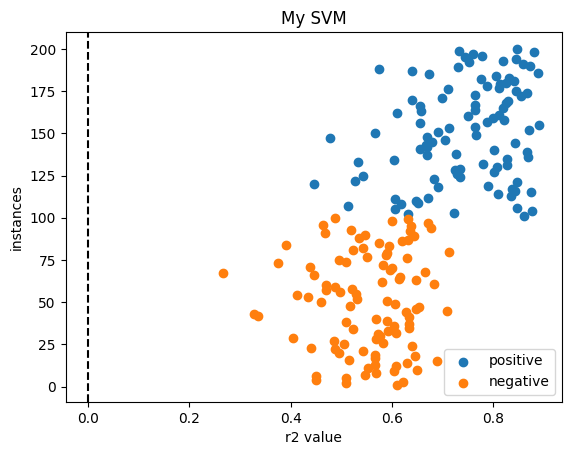

In [33]:
threshold = 0

positive_inputs, positive_labels = dataset.filter_by_label(1)
negative_inputs, negative_labels = dataset.filter_by_label(-1)

positive_x = range(1, len(positive_inputs) + 1)
negative_x = range(1, len(negative_inputs) + 1)

plt.axvline(x=threshold, color='k', linestyle='--')
plt.scatter(positive_inputs, range(101, 201), label="positive")
plt.scatter(negative_inputs, range(1, 101), label="negative")

plt.title('My SVM')
plt.xlabel('r2 value')
plt.ylabel('instances')
plt.legend()
plt.show()

### sklearn SVM

In [21]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score

# Print the shapes to debug
print(f"train_inputs shape: {dataset.train_inputs.shape}")
print(f"test_inputs shape: {dataset.test_inputs.shape}")
print(f"train_labels shape: {dataset.train_labels.shape}")
print(f"test_labels shape: {dataset.test_labels.shape}")

# Reshape inputs if they are 1-dimensional
if dataset.train_inputs.ndim == 1:
    dataset.train_inputs = dataset.train_inputs.reshape(-1, 1)
if dataset.test_inputs.ndim == 1:
    dataset.test_inputs = dataset.test_inputs.reshape(-1, 1)

# Ensure labels are 1-dimensional
if dataset.train_labels.ndim != 1:
    dataset.train_labels = dataset.train_labels.ravel()
if dataset.test_labels.ndim != 1:
    dataset.test_labels = dataset.test_labels.ravel()

# Print the shapes after reshaping
print(f"train_inputs shape after reshape: {dataset.train_inputs.shape}")
print(f"test_inputs shape after reshape: {dataset.test_inputs.shape}")
print(f"train_labels shape after reshape: {dataset.train_labels.shape}")
print(f"test_labels shape after reshape: {dataset.test_labels.shape}")

svm_linear = SVC(kernel="linear")
svm_linear.fit(dataset.train_inputs, dataset.train_labels)

y_pred = svm_linear.predict(dataset.test_inputs)

accuracy = accuracy_score(dataset.test_labels, y_pred)
print(f'Accuracy: {accuracy:.2f}')

# Detailed classification report
print(classification_report(dataset.test_labels, y_pred))


train_inputs shape: (160,)
test_inputs shape: (40,)
train_labels shape: (160, 1)
test_labels shape: (40, 1)
train_inputs shape after reshape: (160, 1)
test_inputs shape after reshape: (40, 1)
train_labels shape after reshape: (160,)
test_labels shape after reshape: (40,)
Accuracy: 0.85
              precision    recall  f1-score   support

          -1       0.79      0.95      0.86        20
           1       0.94      0.75      0.83        20

    accuracy                           0.85        40
   macro avg       0.86      0.85      0.85        40
weighted avg       0.86      0.85      0.85        40



Weights (coefficients): [[6.27064041]]
Intercept (bias): [-4.19357497]


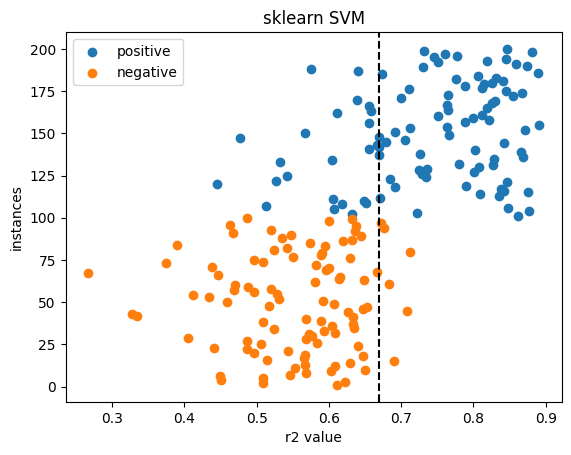

In [31]:
weights = svm_linear.coef_
intercept = svm_linear.intercept_

print("Weights (coefficients):", weights)
print("Intercept (bias):", intercept)

threshold = -intercept / weights

positive_inputs, positive_labels = dataset.filter_by_label(1)
negative_inputs, negative_labels = dataset.filter_by_label(-1)

positive_x = range(1, len(positive_inputs) + 1)
negative_x = range(1, len(negative_inputs) + 1)

plt.axvline(x=threshold, color='k', linestyle='--')
plt.scatter(positive_inputs, range(101, 201), label="positive")
plt.scatter(negative_inputs, range(1, 101), label="negative")

plt.title('sklearn SVM')
plt.xlabel('r2 value')
plt.ylabel('instances')
plt.legend()
plt.show()
